In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.losses import categorical_crossentropy


C:\Users\POOJYANTH REDDY\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\POOJYANTH REDDY\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 

In [3]:
def load_and_process_images(path_dir, class_labels, target_num_images):
    images = []
    labels = []
    min_images = 99999999
    class_images = {}
    
    for label, class_name in enumerate(class_labels):
        class_dir = os.path.join(path_dir, class_name)
        class_images[class_name] = []
        
        if not os.path.exists(class_dir):
            print(f"Directory '{class_name}' not found in '{path_dir}'. Skipping...")
            continue
        
        for jpg in os.listdir(class_dir):
            image_path = os.path.join(class_dir, jpg)
            image_high_resolution = cv2.imread(image_path)
            
            if image_high_resolution is None:
                print(f"Could not read image '{jpg}' in '{class_name}' directory. Skipping...")
                continue
            
            # print(f"Reading image '{jpg}' in '{class_name}' directory...")
            image_change_color = cv2.cvtColor(image_high_resolution, cv2.COLOR_BGR2RGB)
            image_low_resolution = cv2.resize(image_change_color, (200, 200))
            class_images[class_name].append(image_low_resolution)
            min_images = min(min_images, len(class_images[class_name]))
        print(f"Class '{class_name}' has {len(class_images[class_name])} images.")


    for class_name, images_list in class_images.items():
        if len(images_list) > target_num_images:
            images.extend(images_list[:target_num_images])
            labels.extend([class_name] * target_num_images)
        else:
            images.extend(images_list)
            labels.extend([class_name] * len(images_list))
    
    return np.asarray(images), np.asarray(labels), min_images, class_images



dataset_directory = './Datasets/DataImages/'
class_labels = ['Catla', 'Cyprinus carpio', 'Grass Carp', 'Mori', 'Rohu', 'Silver']
target_num_images = 50

images, labels, min_images, class_images = load_and_process_images(dataset_directory, class_labels, target_num_images)

print(f"Number of images: {len(images)}")
print(f"Number of labels: {len(labels)}")


Class 'Catla' has 20 images.
Class 'Cyprinus carpio' has 50 images.
Class 'Grass Carp' has 11 images.
Class 'Mori' has 70 images.
Class 'Rohu' has 73 images.
Class 'Silver' has 47 images.
Number of images: 228
Number of labels: 228


In [4]:
def Image_Populator(class_images, min_images, method='flip'):
    new_images = []
    new_labels = []
    
    for class_name, images in class_images.items():
        num_images = len(images)
        if num_images < min_images:
            num_to_generate = min_images - num_images
            print(f"Populating class '{class_name}' with {num_to_generate} new images using {method}...")
            
            for i in range(num_to_generate):
                original_image = images[i % num_images]
                if method == 'rotate_180':
                    new_image = np.rot90(original_image, 2)
                elif method == 'flip':
                    new_image = np.fliplr(original_image)
                elif method == 'rotate_270':
                    new_image = np.rot90(original_image, 3)
                elif method == 'rotate_90':
                    new_image = np.rot90(original_image)
                elif method == 'flip_rotate_270':
                    new_image = np.rot90(np.fliplr(original_image), 3)
                
                new_images.append(new_image)
                new_labels.append(class_name)
    
    return np.asarray(new_images), np.asarray(new_labels)


In [5]:
if len(images) == 0:
    print("No images found. Exiting...")
else:
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

    # Choose one of the methods: 'rotate_180', 'flip', 'rotate_270', 'rotate_90', 'flip_rotate_270'
    method = 'rotate_180'
    X_train_new, y_train_new = Image_Populator(class_images, target_num_images, method)

    print(X_train_new.shape)
    print(f"Number of new labels: {len(y_train_new)}")

    # Concatenate the original training data with the new generated data
    X_train = np.concatenate([X_train, X_train_new])
    y_train = np.concatenate([y_train, y_train_new])

    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.fit_transform(y_test)

Populating class 'Catla' with 30 new images using rotate_180...
Populating class 'Grass Carp' with 39 new images using rotate_180...
Populating class 'Silver' with 3 new images using rotate_180...
(72, 200, 200, 3)
Number of new labels: 72




Epoch 1/10

8/8 [==============================] - 25s 2s/step - loss: 262.8227
Epoch 2/10
8/8 [==============================] - 19s 2s/step - loss: 261.8914
Epoch 3/10
8/8 [==============================] - 19s 2s/step - loss: 262.9736
Epoch 4/10
8/8 [==============================] - 19s 2s/step - loss: 262.2055
Epoch 5/10
8/8 [==============================] - 19s 2s/step - loss: 262.7641
Epoch 6/10
8/8 [==============================] - 19s 2s/step - loss: 262.7990
Epoch 7/10
8/8 [==============================] - 19s 2s/step - loss: 263.0085
Epoch 8/10
8/8 [==============================] - 19s 2s/step - loss: 262.8339
Epoch 9/10
8/8 [==============================] - 19s 2s/step - loss: 262.7990
Epoch 10/10
8/8 [==============================] - 19s 2s/step - loss: 262.9735
Epoch 1/10

8/8 [==============================] - 26s 2s/step - loss: 1.8324 - accuracy: 0.1457
Epoch 2/10
8/8 [==============================] - 19s 2s/step - loss: 1.7607 - accuracy: 0.3031
Epoch 3/10
8/

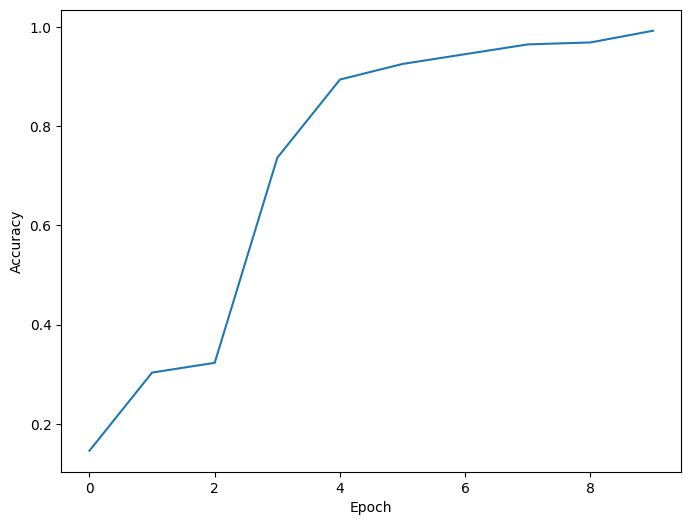

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

batch_size = 32

class ContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=1.0, name="contrastive_loss"):
        super(ContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def call(self, y_true, y_pred):
        # Normalize embeddings
        y_pred = tf.math.l2_normalize(y_pred, axis=1)
        
        # Convert y_true to float32 for compatibility
        y_true = tf.cast(y_true, tf.float32)
        
        # Compute pairwise dot product similarity
        similarity_matrix = tf.matmul(y_pred, y_pred, transpose_a=False, transpose_b=True)
        
        # Scale the similarity matrix by the temperature parameter
        similarity_matrix /= self.temperature
        
        # Compute contrastive loss
        contrastive_loss = -tf.reduce_mean(
            tf.reduce_sum(y_true * tf.math.log_softmax(similarity_matrix, axis=1), axis=1)
        )
        
        return contrastive_loss



    

# Define SimCLR model
def create_simclr_model(input_shape, num_classes):
    base_encoder = ResNet152(include_top=False, weights='imagenet', input_shape=input_shape)
    base_encoder.trainable = False
    
    inputs = layers.Input(shape=input_shape, name='input_image')
    
    x = base_encoder(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)

    model = models.Model(inputs=inputs, outputs=x, name='simclr_model')
    return model

# Create SimCLR model
input_shape = (200, 200, 3)  # adjust based on your image size
num_classes = len(class_labels)
simclr_model = create_simclr_model(input_shape, num_classes)

# Contrastive loss function
contrastive_loss = ContrastiveLoss()

# Compile the model
simclr_model.compile(optimizer=Adam(), loss=contrastive_loss)

# Prepare data for SimCLR training
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(len(X_train)).batch(batch_size)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train_encoded).shuffle(len(y_train_encoded)).batch(batch_size)
train_dataset = tf.data.Dataset.zip((train_dataset, train_labels_dataset))

# Train the model
epochs = 10  # adjust as needed
simclr_model.fit(train_dataset, epochs=epochs)

# Fine-tune the SimCLR model for classification
classification_model = models.Sequential([
    simclr_model,
    layers.Dense(num_classes, activation='softmax')
])

classification_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Prepare data for classification training
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).batch(batch_size)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train_encoded).batch(batch_size)
train_dataset = tf.data.Dataset.zip((train_dataset, train_labels_dataset))

# Train the classification model
history = classification_model.fit(train_dataset, epochs=epochs)

# Evaluate the model
test_dataset = tf.data.Dataset.from_tensor_slices(X_test).batch(batch_size)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test_encoded).batch(batch_size)
test_dataset = tf.data.Dataset.zip((test_dataset, test_labels_dataset))


plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [7]:
accuracy = classification_model.evaluate(test_dataset)[1]
print(f"Accuracy on the test set: {accuracy}")

2/2 [==============================] - 6s 1s/step - loss: 1.2712 - accuracy: 0.9348
Accuracy on the test set: 0.9347826242446899


In [8]:
from sklearn.metrics import classification_report

predictions = classification_model.predict(X_test)

predicted_classes = np.argmax(predictions, axis=1)

class_names = class_labels  # Assuming class_labels is a list of strings

# Convert class_names to a dictionary for easy lookup
class_dict = {class_name: i for i, class_name in enumerate(class_names)}

# Convert string labels in y_test to integers
y_test_int = np.array([class_dict[label] for label in y_test])

for i in range(len(y_test_int)):
    true_class = class_names[y_test_int[i]]
    predicted_class = class_names[predicted_classes[i]]
    print(f"{true_class}, {predicted_class}")

print(classification_report(y_test_int, predicted_classes, target_names=class_names))


2/2 [==============================] - 6s 1s/step
Silver, Silver
Cyprinus carpio, Cyprinus carpio
Catla, Catla
Silver, Silver
Catla, Catla
Silver, Silver
Cyprinus carpio, Cyprinus carpio
Silver, Silver
Rohu, Rohu
Mori, Mori
Silver, Silver
Catla, Cyprinus carpio
Mori, Mori
Rohu, Rohu
Silver, Silver
Rohu, Rohu
Rohu, Rohu
Cyprinus carpio, Cyprinus carpio
Silver, Silver
Silver, Silver
Mori, Mori
Rohu, Rohu
Silver, Silver
Rohu, Rohu
Mori, Rohu
Catla, Catla
Rohu, Rohu
Mori, Mori
Mori, Mori
Mori, Mori
Silver, Silver
Cyprinus carpio, Cyprinus carpio
Mori, Mori
Cyprinus carpio, Cyprinus carpio
Catla, Catla
Mori, Mori
Rohu, Rohu
Mori, Rohu
Mori, Mori
Rohu, Rohu
Mori, Mori
Rohu, Rohu
Rohu, Rohu
Grass Carp, Grass Carp
Mori, Mori
Mori, Mori
                 precision    recall  f1-score   support

          Catla       1.00      0.80      0.89         5
Cyprinus carpio       0.83      1.00      0.91         5
     Grass Carp       1.00      1.00      1.00         1
           Mori       1.00      0